# CNN to classify plant sleedling images
- Kat Bardash, Regis University, Deep Learning
- October 8, 2018

## 1. Purpose & data
- The purpose of this file is to create a Convoluntional Neural Network (CNN) and Inception model using keras to classify plant seedling images. Data was downloaded from https://www.kaggle.com/c/plant-seedlings-classification/data to a local drive and then uploaded to a Google Drive to save time while using colab. AWS was also used concurrently to same time in processing. 

- If no changes need to be made in preprocessing, skip to just before section 4 for preloaded numpy objects.

- The sections are:
    1. Purpose & Data (this section)
    2. Loading Data & PreProcessing
    3. More Data PreProcessing
    4. Sequential CNN, 28x28
    5. Sequential CNN, 51x51
    6. Inception Model, 28x28
    7. AWS
    8. Submitting to Kaggle
    9. Conclusions
    + References

In [1]:
#### Loading in Data using google drive
#REFERENCE https://colab.research.google.com/drive/1srw_HFWQ2SMgmWIawucXfusGzrj1_U0q#scrollTo=H4SJ-tGNkOeY
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
#!ls "/content/drive/My Drive/Colab Notebooks/PlantsProject/train"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#change directory to PlantsProject in Google Drive
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/PlantsProject/")
#!ls

# load libraries
import numpy
import pandas as pd
import time
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Concatenate, Dense, Dropout, Flatten, Activation, concatenate
from keras.utils import to_categorical
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing import image
from sklearn.preprocessing import OneHotEncoder
from keras import backend as K
from keras.optimizers import Adam
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow
from keras.callbacks import EarlyStopping, ModelCheckpoint
#hyper optimization
!pip install hyperopt
!pip install hyperas
from __future__ import print_function
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

K.set_image_dim_ordering( 'tf' )


Using TensorFlow backend.


    100% |████████████████████████████████| 122kB 8.0MB/s 
    100% |████████████████████████████████| 409kB 20.3MB/s 
    100% |████████████████████████████████| 112kB 7.9MB/s 
    100% |████████████████████████████████| 112kB 26.8MB/s 
    100% |████████████████████████████████| 337kB 24.7MB/s 
    100% |████████████████████████████████| 2.2MB 14.7MB/s 
  Running setup.py bdist_wheel for hyperas ... - \ done
  Stored in directory: /root/.cache/pip/wheels/06/38/3f/27826f57fae60ef788ceb47e2c649590ab8af31f42075325d2
Successfully built hyperas
ipython 5.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.4, but you'll have prompt-toolkit 2.0.6 which is incompatible.
  Found existing installation: prompt-toolkit 1.0.15
    Uninstalling prompt-toolkit-1.0.15:
      Successfully uninstalled prompt-toolkit-1.0.15


## 2. Loading Data & Pre-processing
- There are 12 categories of seedling images as seen below with 221 to 611 images in each.
- There are a total of 4750 color images available for this task.
- Initial image size is 1816 X 1816 pixels
- A sample image is displayed below

12
Black-grass 263 images
Charlock 390 images
Cleavers 287 images
Common Chickweed 611 images
Common wheat 221 images
Fat Hen 475 images
Loose Silky-bent 654 images
Maize 221 images
Scentless Mayweed 516 images
Shepherds Purse 231 images
Small-flowered Cranesbill 496 images
Sugar beet 385 images


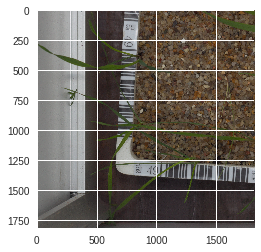

In [63]:
#creating categories of plant seeds
CATEGORIES = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent',
              'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
NUM_CATEGORIES = len(CATEGORIES)
print(NUM_CATEGORIES)

#create directory of files
data_dir = ("/content/drive/My Drive/Colab Notebooks/PlantsProject")
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
sample_submission = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))

# this shows the sample submission csv
sample_submission.head(2)

#Prints the number of images in each category
#.format does string formatting - here it prints the category in each CATEGORY, and takes the file path of train with the category file path, joins them, then makes a list & finds out how many files are in there

for category in CATEGORIES:
    print('{} {} images'.format(category, len(os.listdir(os.path.join(train_dir, category)))))
    
    
#what is the image size?  1816 X 1816
%matplotlib inline
im= Image.open("train/Black-grass/f84089a55.png")
width, height = im.size
img = mpimg.imread("train/Black-grass/f84089a55.png")
imgplot = plt.imshow(img)
plt.show()

- The next section loads each image as an numpy array and creates a list of training images and training labels.
- This section takes about 50 minute to run. In order to save time between sessions on working on the project, I saved these as numpy array objects so I could quickly load them. I saved one as 28 X 28 sized images and another as 51 X51 for comparison. The code is shown for 28 X 28, but 51 x51 was done by changing output values and names and saved so code is not shown.
- Initially I used a similar but different method to pre-process the images with the function LabelBinarizer() to turn labels into numerical binary labels.  You can see the code commented out at the bottom of this section

In [7]:
#testing 1 image
#img = image.load_img('train/Black-grass/f84089a55.png', target_size=(128,128))
#x = image.img_to_array(img)
#x

#IMAGE PRE PROCESSING
#THIS PIECE TAKES ABOUT 50 MINUTES - see code below for saved numpy array file
t0=time.time()

#create list of image arrays & labels
import glob
train_imgs = [] #initialize new list
train_label = [] #initialize new list


train_dir = '/content/drive/My Drive/Colab Notebooks/PlantsProject/train/*/*.png'

for img_dir in glob.glob(train_dir):
  img = image.load_img(img_dir, target_size = (28,28)) #
  x = image.img_to_array(img)
  train_imgs.append(x)
  train_label.append(img_dir.split('/')[-2]) #takes 2nd from end element which would be label
  
t1=time.time()
print(t1-t0, "seconds")  #takes about 51 minutes
print(len(train_imgs))
print(len(train_label))

############## SAVE AS NUMPY ARRAY OBJECTS

#save labels to predict for kaggle comp later
train_labelB = train_label
numpy.save('train_labelB', train_labelB)

#convert lists to numpy array
train_imgs = numpy.asarray(train_imgs)
train_label = numpy.asarray(train_label)

#save numpy arrarys for I don't have to do steps above
numpy.save('train_imgs', train_imgs)
numpy.save('train_label', train_label)

##############


### Alternate way of pre-processing images - first method I used
  #reshapes, normalizes, converts labels to numerical then binary
  #reshape images & resize
#images = np.array([np.array(im) for im in train_imgs]) #create nparray for each image, then create np array of ALL nparrays of imgs
#images = images.reshape(images.shape[0], 128, 128, 3) / 255 # Why do I have images.shape[0]? this gives me 128 - first element of shape
  #change labels to multiclass binary labels
#lb = LabelBinarizer().fit(train_label)  #fits label Binarizer
#label = lb.transform(train_label) #transforms to multiclass binary # reference http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html

1902.4218463897705 seconds
4750
4750


##  3. More Data Preprocessing
- This section splits the data into a training/validation set of 80/20.
- There are 2 sections - one for processing images at 28X28, the other for the same steps but outputting 51 X 51 (processing done earlier and saved as numpy array)
- The images are reshaped to 28 X 28 X 3 and converted to float32 type
- The arrays are normalized by diving by 255 (because integer image values range from 0 to 255) to scale the values from 0 to 1
- Category labels are integer encoded since they are character (Black-grass), then one-hot encoded into 12 categories
    + I could have avoided the step of integer encoding by creating a df with categories already integer encoded using enumerate() function
    + LabelBinarizer().fit() and lb.transform() could also be used for this same task (code is commented out below)
    
  
  ### 28 X 28 below

In [0]:
#pre load numpy arrays from above
train_imgs = numpy.load('train_imgs.npy')
train_label = numpy.load('train_label.npy')

#### 28 X 28 version
# split into test/train set 
trainX, validX, trainY, validY = train_test_split(train_imgs, train_label, test_size=0.2) #80/20 split, shuffle=TRUE default

#reshape to be samples, width, height, channel
trainX = trainX.reshape(trainX.shape[0], 28, 28,3).astype('float32')
validX = validX.reshape(validX.shape[0], 28, 28,3).astype('float32')

#normalize inputs from 0-255 to 0-1
#always 255 because image data is encoded as integers in 0-255 range
trainX = trainX /255
validX = validX / 255

#reference that I needed to integer code first https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/
#integer encode
label_encoder = LabelEncoder()
trainY = label_encoder.fit_transform(trainY)
validY = label_encoder.fit_transform(validY)

#one hot encode outputs - turn to integers first, then one hot encode
trainY = to_categorical(trainY)
validY = to_categorical(validY)

#### same 28 X 28 reshaped version as numpy array
#same to numpy array object

numpy.save('trainX', trainX)
numpy.save('trainY', trainY)
numpy.save('validX', validX)
numpy.save('validY', validY)



### 51 X 51 below

In [0]:
# 51 X 51 version

train_imgs2 = numpy.load('train_imgs2.npy')
train_label2 = numpy.load('train_label2.npy')

# split into test/train set 
trainX2, validX2, trainY2, validY2 = train_test_split(train_imgs2, train_label2, test_size=0.2) #80/20 split, shuffle=TRUE default

#reshape to be samples, width, height, channel
trainX2 = trainX2.reshape(trainX2.shape[0], 51, 51,3).astype('float32')
validX2 = validX2.reshape(validX2.shape[0], 51, 51,3).astype('float32')

#normalize inputs from 0-255 to 0-1
#always 255 because image data is encoded as integers in 0-255 range
trainX2 = trainX2 /255
validX2 = validX2 / 255

#reference that I needed to integer code first https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/
#integer encode
label_encoder = LabelEncoder()
trainY2 = label_encoder.fit_transform(trainY2)
validY2 = label_encoder.fit_transform(validY2)

#one hot encode outputs - turn to integers first, then one hot encode
trainY2 = to_categorical(trainY2)
validY2 = to_categorical(validY2)

#alternate way of converting labels
#lb = LabelBinarizer().fit(train_label)  #fits label Binarizer
#label = lb.transform(train_label) #transforms to multiclass binary # reference http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html

#### same 51 X 51 reshaped version as numpy array
#same as  numpy array object
numpy.save('trainX2', trainX2)
numpy.save('trainY2', trainY2)
numpy.save('validX2', validX2)
numpy.save('validY2', validY2)

### Fully preprocessed 28X28 and 51X51 numpy array objects below
- After mounting Google Drive and loading libraries, I can skip to this step.

In [45]:
#load 28X28 versions of preprocessed arrays
trainX = numpy.load("trainX.npy")
trainY = numpy.load("trainY.npy")
validX = numpy.load("validX.npy")
validY = numpy.load("validY.npy")

#load 51 X51 versions of preprocessed arrays
trainX2 = numpy.load("trainX2.npy")
trainY2 = numpy.load("trainY2.npy")
validX2 = numpy.load("validX2.npy")
validY2 = numpy.load("validY2.npy")

#verify shapes
print(trainX2.shape)
print(trainY2.shape)
print(validX2.shape)
print(validY2.shape)

print(trainX.shape)
print(trainY.shape)
print(validX.shape)
print(validY.shape)


(3800, 51, 51, 3)
(3800, 12)
(950, 51, 51, 3)
(950, 12)
(3800, 28, 28, 3)
(3800, 12)
(950, 28, 28, 3)
(950, 12)


# 4. Model #1 - Sequential CNN

- My first attempt was with a **very basic Convolutional Network** (see layers below). Although this yielded the **best results in terms of not overfitting**, the model only produced an accuracy of about 80%

    + Input image shape = 28,28,3
    + Conv2D/MaxPooling (4 times repeated) - filters: 32, 64, 128, 128
    + Flatten, Dense (512), Dense (12)
    + all activations are relu, except last dense layer = softmax
    + Epochs = 50, Batch=16


- I then attempted to** deepen the layers on the model, but added batch normalization to try and prevent overfitting.**  I tried a variety of learning rates (0.001 to 0.00001) **but all models overfit  **and the best accuracy I achieved was with** 8.84% on a lr of .0001. ** This model took 4197 seconds to run in Colab. The model structure is below.
    + X2 repeating layers [Cov2D/BatchNorm X2, then Max pool ]  64 filters in 1st two / 128 in 
       2nd two
    + X2 repeating layers  Conv/Batch/Max  - 256/256 filters
    + Flatten, Dense(512), Dense(12, softmax)
    + all activations are relu, except last dense layer = softmax
    + Epochs= 50, Batch=16
    

- Then, I realized that I did not include batch normalization after ever Conv2D layer and every Dense layer, so I did that. I also **changed the starting number of filters to 32 since starting with 64 and increasing overfit the model.** I  **experimented with epsilon as 0.1 as per the Chollet book, but this did not improve accurary or help overfitting. ** I also increased the batch-size to 20 from 16 and decreased epochs from 50 to 25 for time purposes. This model did not converge so I reran for 50 epochs, but that also did not converge.  The best accuracy I got was 8.11% with time of 1734 and lr of 0.001, but the model seems to be overfitting/not converging. The run with 50 epochs produced a worse error rate and still did not converge.

- I then tried removing layers (2-Conv2D, Batch, Max Pool) to try and get my model to stop from overfitting. This obviously lowered the accuracy, but did not help overfitting

- At this point,** I augmented my data and saw that it was also overfitting.** The augmentation process was rotating, width shift, height shift, zoom range, horizontal_flip, vertical_flip, and fill mode (for creating new pixels).** I removed rotation and width shift and this seemed to help bring validation up. ** I also adjusted the **filter window to 1X1** and with lr of 0.001, this produced the best accuracy yet - 7.79% and was getting close to not overfitting. Batch was still 16 and epochs were still 30.

- I wondered if** image size could change the overfitting or accuracy,** so I reshaped the images to 51X51 and ran the model under the same conditions as above, but this yielded an accuracy of 10.21%.

- At this point** all my models except the very first one are ranging wildly in the validation accuracy. ** There are large spikes which I imagine is from the batch size. There are 12 categories and if I am using only 16 images in each batch, there could be a type throwing the model off or it doesn't have enough to train on in those batches.

- I **tried to increase the batch size to 50 to reduce the wild spikes, and using an image size of 28 X 28 with same model construction described above, I got a model that overfit and did not perform better on accuracy. ** (epochs = 50, batch size=50)

- On AWS, I **experimented with hyper optimization using hyperas.** The idea is that the weights are only updated if they improve the loss. Running the same CNN model with 28X28 image size above produced at best an accuracy of 73.68% with lr of 0.001.


- Running CNN below, 50 epochs, 16 batch size, lr=0.001, with **early stopping  = 10.** Mode overfitting, so will try regularization. Accuracy 8.2%

- **Tried LeakyReLU **with same model as above - error at 15%

 
 



### CNN described above trained on 28 X 28 size image

In [0]:
from keras import regularizers
from keras.layers.advanced_activations import LeakyReLU

# DONE #1) add more conv layers
#DONE #2) add batch norm after dense
# DONE#3) reduce the amount of filters - overfitting!
#44 potentially reduce augmentation
#4) add hyper optimization  https://github.com/maxpumperla/hyperas
#5) beta1=0.9, beta2=0.999, epsilon=0.1 ** try
# try k-fold cross val #https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/
def model1(lr) :
  model = Sequential()
  model.add(Conv2D(32, (1,1), activation = 'relu', input_shape=(28,28,3))) # MAKE SURE TO CHANGE IF NEEDED
  model.add(BatchNormalization())
  model.add(Conv2D(32, (1,1), activation = 'relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(2,2))
  
  model.add(Conv2D(64, (1,1), activation = 'relu', padding='same')) #NEED TO KEEP PADDING = SAME or get weird negative error
  model.add(BatchNormalization())
  model.add(Conv2D(64, (1,1), activation = 'relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(2,2))
  
  model.add(Conv2D(128, (1,1), activation = 'relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(128, (1,1), activation = 'relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(2,2))

  model.add(Flatten())
  model.add(Dense(128 ))
  #, activation='relu', kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.01)
  model.add(BatchNormalization())
  model.add(Dense(12, activation='softmax'))
  
  adam=Adam(lr=lr)
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  
  return model

#build model
model = model1(.001)


### Data Augmentation
- This model uses data augmentation from ImageDataGenerator() from keras.preprocessing. The images are rotated, shifted, flipped, and zoomed in on in real-time during the training process.

Epoch 1/16
2375/2375 [==============================] - 71s 30ms/step - loss: 0.7970 - acc: 0.7352 - val_loss: 0.7928 - val_acc: 0.7305
Epoch 2/16
2375/2375 [==============================] - 68s 29ms/step - loss: 0.5163 - acc: 0.8256 - val_loss: 0.6772 - val_acc: 0.7779
Epoch 3/16
2375/2375 [==============================] - 68s 29ms/step - loss: 0.4395 - acc: 0.8485 - val_loss: 0.7649 - val_acc: 0.7537
Epoch 4/16
2375/2375 [==============================] - 68s 29ms/step - loss: 0.4002 - acc: 0.8618 - val_loss: 0.7553 - val_acc: 0.7495
Epoch 5/16
2375/2375 [==============================] - 68s 29ms/step - loss: 0.3534 - acc: 0.8786 - val_loss: 0.4620 - val_acc: 0.8368
Epoch 6/16
2375/2375 [==============================] - 68s 29ms/step - loss: 0.3355 - acc: 0.8815 - val_loss: 0.4066 - val_acc: 0.8558
Epoch 7/16
2375/2375 [==============================] - 68s 29ms/step - loss: 0.3140 - acc: 0.8906 - val_loss: 0.4070 - val_acc: 0.8705
Epoch 8/16
2375/2375 [==========================

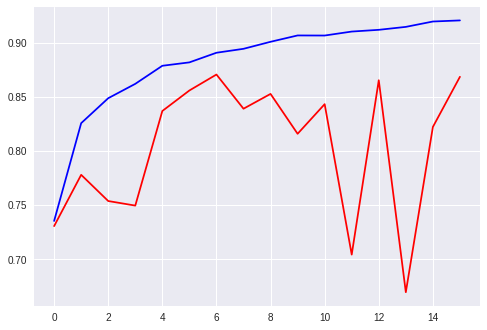

In [13]:
#Augment Data #Reference https://machinelearningmastery.com/image-augmentation-deep-learning-keras/
datagen = ImageDataGenerator(
    rotation_range = 30,  # tried 40
    width_shift_range = 0.2,
    #height_shift_range = 0.2,
    zoom_range=0.3,
    #horizontal_flip=True,
    vertical_flip=True,
    fill_mode = 'nearest') #fills in newly created pizels

BATCH_SIZE = 16
EPOCHS = 16
datagen.fit(trainX) #validation should not be augmented, it's like a test

for lr in [0.001 ]:
  #build model
  model = model1(lr)
  
    #early stopping
  #early_stopping = EarlyStopping(monitor='val_loss', patience=20)
  #checkpointer = ModelCheckpoint(filepath='keras_weights.hdf5',
                                   #verbose=1,
                                  # save_best_only=True)
  
  t0 = time.time()
  log2 = model.fit_generator(datagen.flow(trainX, trainY, batch_size=BATCH_SIZE), 
                             epochs=EPOCHS, 
                             steps_per_epoch=10*len(trainX)/BATCH_SIZE,
                             verbose = 1,
                             shuffle = True, 
                             #callbacks=[early_stopping,checkpointer],
                             validation_data = (validX, validY) )

  t1 = time.time()
  print(t1-t0, "seconds")   

  #final eval
  scores = model.evaluate(validX, validY, verbose=0)
  print("CNN Error: %.2f%%" % (100-scores[1]*100))
  
  plt.plot(log2.history['acc'],'b') 
  plt.plot(log2.history['val_acc'],'r')
  plt.show()

In [0]:
model.save("bestmodel.h5")

### CNN described above trained on 51 X 51 size image
- using trainX2.npy file
- Using the same model and hyper parameters that gave the best accuracy above, I trained the model on 51X51 to see if this might improve anything.
- Error rate was 10.2% and model was still overfitting so I won't use 51 X 51.

Epoch 1/30
2375/2375 [==============================] - 113s 48ms/step - loss: 0.6753 - acc: 0.7717 - val_loss: 0.4936 - val_acc: 0.8200
Epoch 2/30
2375/2375 [==============================] - 101s 43ms/step - loss: 0.3944 - acc: 0.8640 - val_loss: 1.3591 - val_acc: 0.6084
Epoch 3/30
2375/2375 [==============================] - 99s 42ms/step - loss: 0.3091 - acc: 0.8929 - val_loss: 0.5215 - val_acc: 0.8137
Epoch 4/30
2375/2375 [==============================] - 101s 42ms/step - loss: 0.2690 - acc: 0.9056 - val_loss: 0.5909 - val_acc: 0.8053
Epoch 5/30
2375/2375 [==============================] - 102s 43ms/step - loss: 0.2318 - acc: 0.9161 - val_loss: 0.7150 - val_acc: 0.7800
Epoch 6/30
2375/2375 [==============================] - 103s 43ms/step - loss: 0.2197 - acc: 0.9214 - val_loss: 0.4302 - val_acc: 0.8663
Epoch 7/30
2375/2375 [==============================] - 102s 43ms/step - loss: 0.1978 - acc: 0.9283 - val_loss: 0.4931 - val_acc: 0.8579
Epoch 8/30
2375/2375 [====================

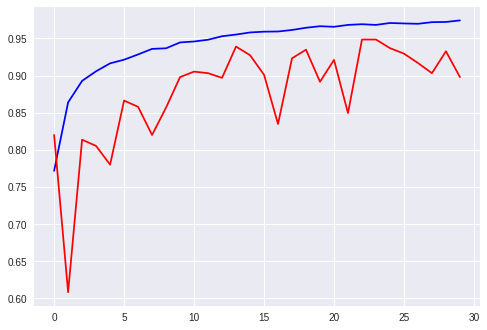

In [29]:
def modelConv51(lr) :
  model = Sequential()
  model.add(Conv2D(32, (1,1), activation='relu', input_shape=(51,51,3))) # MAKE SURE TO CHANGE IF NEEDED
  model.add(BatchNormalization())
  model.add(Conv2D(32, (1,1), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(2,2))
  
  model.add(Conv2D(64, (1,1), padding='same', activation='relu')) #NEED TO KEEP PADDING = SAME or get weird negative error
  model.add(BatchNormalization())
  model.add(Conv2D(64, (1,1), activation='relu'))
  model.add(BatchNormalization(axis=3))
  model.add(MaxPooling2D(2,2))
  
  model.add(Conv2D(128, (1,1), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(128, (1,1), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(2,2))

  
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dense(12, activation='softmax'))
  
  adam=Adam(lr=lr)
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

#build model
model = modelConv51(.001)


#Augment Data #Reference https://machinelearningmastery.com/image-augmentation-deep-learning-keras/
datagen = ImageDataGenerator(
    #rotation_range = 30,  # tried 40
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    #zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode = 'nearest') #fills in newly created pizels

BATCH_SIZE = 16
EPOCHS = 30
datagen.fit(trainX2) #validation should not be augmented, it's like a test

#0.01, .001, .0001, .00001]
for lr in [0.001]:
  #build model
  model = modelConv51(lr)
  
  t0 = time.time()
  log2 = model.fit_generator(datagen.flow(trainX2, trainY2, batch_size=BATCH_SIZE), 
                             epochs=EPOCHS, 
                             steps_per_epoch=10*len(trainX2)/BATCH_SIZE,
                             verbose = 1,
                             shuffle = True, 
                             validation_data = (validX2, validY2) )

  t1 = time.time()
  print(t1-t0, "seconds")   

  #final eval
  scores = model.evaluate(validX2, validY2, verbose=0)
  print("CNN Error: %.2f%%" % (100-scores[1]*100))
  
  #plot model
  plt.plot(log2.history['acc'],'b') 
  plt.plot(log2.history['val_acc'],'r')
  plt.show()

# 5. Inception Model Architecture trained on 28 X 28 sized image
- This model is exactly the Inception architecture from the original paper with 4 separate layers that are concatenated after processing.
- The first run was a batch size of 16, epochs=30 for lr = 0.01 through 0.00001.
- The lr of 0.001 very severly overfit, but lr of 0.01 and .0001 seemed that with more time, the model could improve in accuracy without severe overfitting.
- For a second go, I used lr=0.01, increased epochs to 50. Early stopping did not stop the running of the model, so there may be more accuracy gains to be made.

In [0]:
####INCEPTION MODEL

def inception():
  #input
  inputs = Input(shape=(28,28,3))
  
  ### INCEPTION 2, 1st #### 
  #1X1 filter
  tower1 = Conv2D(32,1, activation='relu', padding='same')(inputs)
  
  #3X3 filter
  tower2 = Conv2D(32,1, activation='relu', padding='same')(inputs)
  tower2 = Conv2D(32,3, activation='relu', padding='same')(tower2)

  #5X5 filter
  tower3 = Conv2D(32,1, activation='relu', padding='same')(inputs)
  tower3 = Conv2D(32,5, activation='relu', padding='same')(tower3)

  #maxpooling
  tower4 = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same')(inputs)
  tower4 = Conv2D(32,1, activation='relu', padding='same')(tower4)

  #concatenate
  concat1 = concatenate([tower1, tower2, tower3, tower4])
  
  #maxpool
  output1 = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same')(concat1)
  
  
  #### INCEPTION 2, 2nd ####
  #1X1 filter
  tower12 = Conv2D(32,1, activation='relu', padding='same')(output1)
  
  #3X3 filter
  tower22 = Conv2D(32,1, activation='relu', padding='same')(output1)
  tower22 = Conv2D(32,3, activation='relu', padding='same')(tower22)

  #5X5 filter
  tower32 = Conv2D(32,1, activation='relu', padding='same')(output1)
  tower32 = Conv2D(32,5, activation='relu', padding='same')(tower32)

  #maxpooling
  tower42 = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same')(output1)
  tower42 = Conv2D(32,1, activation='relu', padding='same')(tower42)

  #concatenate Inception 2
  concat2 = concatenate([tower12, tower22, tower32, tower42])
  
  #maxpool
  output2 = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same')(concat2)
  
  #flatten
  outputs = Flatten()(output2)
  #dense layer 1
  outputs = Dense(128, activation="relu")(outputs)
  #dense  layer 2 output
  outputs = Dense(12, activation="softmax")(outputs)

  model = Model(inputs=inputs, outputs=outputs)
  
  model.compile(loss="categorical_crossentropy",
               optimizer= Adam(lr=.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
               metrics=['accuracy']) 
  return model

#build model
model = inception()

In [74]:
### INCEPTION MODEL

#Augment Data #Reference https://machinelearningmastery.com/image-augmentation-deep-learning-keras/
datagen = ImageDataGenerator(
    rotation_range = 30,  # tried 40
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode = 'nearest') #fills in newly created pizels

datagen.fit(trainX) #validation should not be augmented, it's like a test


#callbacks = [EarlyStopping(monitor='val_loss', patience=4),
             #ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
  
t0 = time.time()
#fit model
log3 = model.fit_generator(datagen.flow(trainX, trainY, 
                             batch_size=20), 
                             epochs=20, 
                             steps_per_epoch=10*len(trainX)/BATCH_SIZE,
                             verbose = 1,
                            # callbacks = callbacks, #early stopping
                             shuffle = True, 
                             validation_data = (validX, validY) )

t1=time.time()
print(t1-t0," seconds")
 
# Final evaluation of the model
scores = model.evaluate(validX, validY, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

 #plot model
  plt.plot(log3.history['acc'],'b') 
  plt.plot(log3.history['val_acc'],'r')
  plt.show()
  


Epoch 1/20
2375/2375 [==============================] - 107s 45ms/step - loss: 1.5575 - acc: 0.4691 - val_loss: 1.1369 - val_acc: 0.5958
Epoch 2/20
2375/2375 [==============================] - 102s 43ms/step - loss: 1.0858 - acc: 0.6336 - val_loss: 1.0561 - val_acc: 0.6242
Epoch 3/20
2375/2375 [==============================] - 102s 43ms/step - loss: 0.8971 - acc: 0.7011 - val_loss: 0.8161 - val_acc: 0.7453
Epoch 4/20
2375/2375 [==============================] - 102s 43ms/step - loss: 0.7619 - acc: 0.7471 - val_loss: 0.7160 - val_acc: 0.7526
Epoch 5/20
2375/2375 [==============================] - 102s 43ms/step - loss: 0.6631 - acc: 0.7773 - val_loss: 0.6655 - val_acc: 0.7705
Epoch 6/20
2375/2375 [==============================] - 102s 43ms/step - loss: 0.5909 - acc: 0.8038 - val_loss: 0.5706 - val_acc: 0.8000
Epoch 7/20
2375/2375 [==============================] - 102s 43ms/step - loss: 0.5377 - acc: 0.8192 - val_loss: 0.5329 - val_acc: 0.8116
Epoch 8/20
2375/2375 [===================

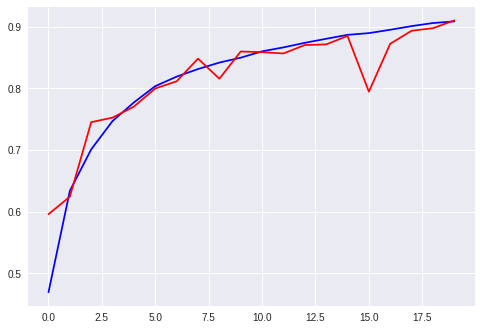

In [75]:
 #plot model
  plt.plot(log3.history['acc'],'b') 
  plt.plot(log3.history['val_acc'],'r')
  plt.show()
  
  model.save("bestmodel.h5")

## Inception Model Tuning
- Increased epochs

Epoch 1/50
2375/2375 [==============================] - 106s 45ms/step - loss: 1.4907 - acc: 0.4891 - val_loss: 1.1461 - val_acc: 0.5989
Epoch 2/50
2375/2375 [==============================] - 102s 43ms/step - loss: 0.9926 - acc: 0.6642 - val_loss: 0.7778 - val_acc: 0.7505
Epoch 3/50
2375/2375 [==============================] - 102s 43ms/step - loss: 0.7669 - acc: 0.7382 - val_loss: 0.6937 - val_acc: 0.7600
Epoch 4/50
2375/2375 [==============================] - 103s 43ms/step - loss: 0.6442 - acc: 0.7796 - val_loss: 0.6435 - val_acc: 0.7779
Epoch 5/50
2375/2375 [==============================] - 102s 43ms/step - loss: 0.5549 - acc: 0.8110 - val_loss: 0.5310 - val_acc: 0.8211
Epoch 6/50
2375/2375 [==============================] - 103s 43ms/step - loss: 0.4924 - acc: 0.8309 - val_loss: 0.4094 - val_acc: 0.8516
Epoch 7/50
2375/2375 [==============================] - 103s 43ms/step - loss: 0.4422 - acc: 0.8472 - val_loss: 0.3999 - val_acc: 0.8568
Epoch 8/50
2375/2375 [===================

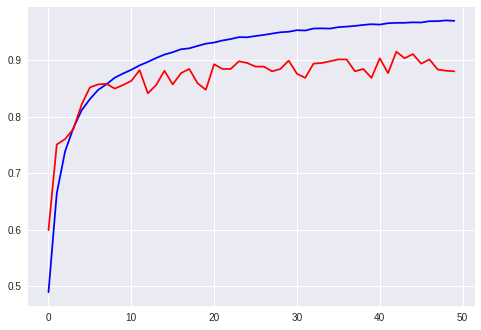

In [77]:
####INCEPTION MODEL

def inception2():
  #input
  inputs = Input(shape=(28,28,3))
  
  ### INCEPTION 2, 1st #### 
  #1X1 filter
  tower1 = Conv2D(32,1, activation='relu', padding='same')(inputs)
  
  #3X3 filter
  tower2 = Conv2D(32,1, activation='relu', padding='same')(inputs)
  tower2 = Conv2D(32,3, activation='relu', padding='same')(tower2)

  #5X5 filter
  tower3 = Conv2D(32,1, activation='relu', padding='same')(inputs)
  tower3 = Conv2D(32,5, activation='relu', padding='same')(tower3)

  #maxpooling
  tower4 = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same')(inputs)
  tower4 = Conv2D(32,1, activation='relu', padding='same')(tower4)

  #concatenate
  concat1 = concatenate([tower1, tower2, tower3, tower4])
  
  #maxpool
  output1 = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same')(concat1)
  
  
  #### INCEPTION 2, 2nd ####
  #1X1 filter
  tower12 = Conv2D(32,1, activation='relu', padding='same')(output1)
  
  #3X3 filter
  tower22 = Conv2D(32,1, activation='relu', padding='same')(output1)
  tower22 = Conv2D(32,3, activation='relu', padding='same')(tower22)

  #5X5 filter
  tower32 = Conv2D(32,1, activation='relu', padding='same')(output1)
  tower32 = Conv2D(32,5, activation='relu', padding='same')(tower32)

  #maxpooling
  tower42 = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same')(output1)
  tower42 = Conv2D(32,1, activation='relu', padding='same')(tower42)

  #concatenate Inception 2
  concat2 = concatenate([tower12, tower22, tower32, tower42])
  
  #maxpool
  output2 = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same')(concat2)
  
  #flatten
  outputs = Flatten()(output2)
  #dense layer 1
  outputs = Dense(128, activation="relu")(outputs)
  #dense  layer 2 output
  outputs = Dense(12, activation="softmax")(outputs)

  model = Model(inputs=inputs, outputs=outputs)
  
  model.compile(loss="categorical_crossentropy",
               optimizer= Adam(lr=.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
               metrics=['accuracy']) 
  return model

#build model
model = inception2()


### INCEPTION MODEL

#Augment Data #Reference https://machinelearningmastery.com/image-augmentation-deep-learning-keras/
datagen = ImageDataGenerator(
    rotation_range = 30,  # tried 40
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode = 'nearest') #fills in newly created pizels

datagen.fit(trainX) #validation should not be augmented, it's like a test


#callbacks = [EarlyStopping(monitor='val_loss', patience=4),
             #ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
  
t0 = time.time()
#fit model
log4 = model.fit_generator(datagen.flow(trainX, trainY, 
                             batch_size=20), 
                             epochs=50, 
                             steps_per_epoch=10*len(trainX)/BATCH_SIZE,
                             verbose = 1,
                            # callbacks = callbacks, #early stopping
                             shuffle = True, 
                             validation_data = (validX, validY) )

t1=time.time()
print(t1-t0," seconds")
 
# Final evaluation of the model
scores = model.evaluate(validX, validY, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

 #plot model
plt.plot(log4.history['acc'],'b') 
plt.plot(log4.history['val_acc'],'r')
plt.show()
  

# 6.Submitting to Kaggle
- Thanks to Srivastav (2018) for code.
- The Kaggle submission is based off the CNN model with 13% accuracy that I saved. I did not save the 7% accuracy model and was not able to achieve the same results again.

In [79]:
from keras.models import load_model
model = load_model('bestmodel.h5')

import glob
from PIL import Image, ImageOps
train_label2 = numpy.load('train_label2.npy')

#binarize the category labels
lb = LabelBinarizer().fit(train_label2)
label = lb.transform(train_label2)

#create testing image directory
test_dir = '/content/drive/My Drive/Colab Notebooks/PlantsProject/test/*.png'
test_imgs=[]
names = []
for timage in glob.glob(test_dir):
    img = Image.open(timage)
    names.append(timage.split('/')[-1])
    test_imgs.append(ImageOps.fit(img,(28, 28),Image.ANTIALIAS).convert('RGB'))

#turn images into integer arrarys and normalize
test_images = numpy.array([numpy.array(im) for im in test_imgs])
test_images_X = test_images.reshape(test_images.shape[0], 28, 28, 3) / 255

#predict and inverse transform ###### REDO THIS DEPENDING ON MODEL USED!!!!
test_y = lb.inverse_transform(model.predict(test_images_X))

#create df
df = pd.DataFrame(data={'file': names, 'species': test_y})
df_sort = df.sort_values(by=['file'])
df_sort.to_csv('resultss.csv', index=False)

print(df_sort)

              file                    species
792  0021e90e4.png  Small-flowered Cranesbill
787  003d61042.png                    Fat Hen
791  007b3da8b.png                 Sugar beet
790  0086a6340.png           Common Chickweed
788  00c47e980.png                 Sugar beet
789  00d090cde.png          Scentless Mayweed
784  00ef713a8.png           Common Chickweed
793  01291174f.png                    Fat Hen
785  026716f9b.png           Loose Silky-bent
786  02cfeb38d.png           Loose Silky-bent
783  03566743d.png                    Fat Hen
778  03a2ee656.png  Small-flowered Cranesbill
781  03e322a29.png                 Sugar beet
777  03ef36742.png          Scentless Mayweed
775  043449b0b.png                 Sugar beet
779  0437393b1.png                    Fat Hen
776  04814f36d.png          Scentless Mayweed
774  05341a8a6.png          Scentless Mayweed
782  060450d79.png           Common Chickweed
780  060f1dc84.png                   Cleavers
773  0625f063b.png           Commo

## 7. AWS
- In order to increase processing power, I signed up for AWS and recruited my cousin to help me set it up.
- After creating an AWS account, I had to generate a keypair, get the AMI instance provided by Professor Kim, get my security group, and decide on the type of instance. Since my cousin does this for a living, he had all of these inputs saved in a handy file so I just had to input all the information and put all this information in and then the code and vagrant did all the work. I also had to load a vagrant plugin for aws which I had to troubleshoot because it didn't work the first time. In my .ssh folder I had to put my .pem key as well as my private key and the.ppk (for Putty to work). After creating and instance on AWS, I navigate to the folder with my vagrant file and type in vagrant up. This loads my AWS instance. I then have to connect via Putty. Whatever I put in folder that has my vagrant file will automatically sync with vagrant.
Things to remember is that if I kill an instance, the IP address that I need to input for Putty will change. 
- I am lucky that I had my cousin who does this for a living help me because it was not an easy process.
- We also ran into some issues running jupyter notebooks and locating the home directory, but I was able to figure most of this out.
- After about half a day of effort, it finally worked! The bad news is that as of right now, even with the recommended GPU size in the Chollet book, CoLab runs faster. Yikes.

## 8. Conclusion

#### Model Comparisons & Methods
- A very basic CNN model as described in section 4 did the best in terms of not overfitting right away. A more involved CNN model with Batch Normalization and extra layers produced the best accuracy.. I found that increasing layers did increase accuracy, but generally at the expense of overfitting. After adding regularization and changing the activation layer to LeakyRELU, I was able to see better accuracy overall and less overfitting. Early stopping proved to be very useful when running multiple models, but I found I had to use a high patience number such as 10 because of the wild swings in my model it was possible that it would still produce gains after 4 epochs. 
- The Inception model gave me a lot of trouble in that it wouldn't work with a high learning rate (.01), epochs of 20 and batch size of 16. It seems like the model needed a smaller learning rate and larger batch size for it to work. In the end, the inception model gave me 8.95% accuracy which was close to the best that I achieved with the CNN model.

#### Best Overall Model & Why It Works
- The CNN model produces the best accuracy because it's not too complex, it has batch normalization and 1X1 filter size to prevent from serious overfitting, but it's deep enough that it produces an accuracy better than the simple model. I experimented with a wide range of options of this model, but in general this did better than the more complex Inception model. I was actually very hopeful that the Inception model would work because it's actually very simple on the surface, but it didn't produce accuracy as well as the CNN and was overfitting. 
- Unfortunately, I did not save the model that resulted in 7% accuracy and have not been able to get close to that again so that's definitely an important lesson learned!

#### Future Improvements 
- I know that I can work on automating some of the hyper optimization, but my I'm limited by time and my Python skills at the moment. The other limiting factor is the processing time on CoLab and AWS (which was slower!!!)
- I tried to be systematic about the processes in that I didn't wildly make changes but came up with a strategy and saw it through by adjusting hyper parameters. 
- I could have tried using a training/validation/ and testing set, but I think part of the issue this time is there may not have been enough of one time of seedling picture in the training set, so splitting up the data even further might have aggravated this problem. I think trying k-fold cross validation next time might be useful since that will do the same type of split but over many folds so I have a better chance of even seedling category distribution in the data.

#### General Thoughs
- I feel this project, in addition to the class, gave me a great overview of the possibilities to fine tune the model. It seems this area is still relatively new and sometimes it does feel like throwing darts blindfolded, but there are general things to watch out for like overfitting by checking graphs, using early stopping with some patience to cycle through iterations of models faster. I did not find little things like changing epsilon in the optimizers to help, but that could be beacuse of the type of data and my lack of throughness in exploring it. 

References:

Albon,C. (2017). Neural network early stopping. Retrieved from https://chrisalbon.com/deep_learning/keras/neural_network_early_stopping/

belua. (2018). Transfer learning with pretrained keras models. Retrieved from https://www.kaggle.com/gaborfodor/seedlings-pretrained-keras-models

Brownlee, J. (2016). How to improve deep learning performance. Retrieved from https://machinelearningmastery.com/improve-deep-learning-performance/

Kazachok, M. (2018). Keras simple model (.97103 best public score). Retrieved from https://www.kaggle.com/miklgr500/keras-simple-model-0-97103-best-public-score

maxpumperla. (2018) hyperas. Retrieved from https://github.com/maxpumperla/hyperas/blob/master/examples/lstm.py

Srivastav, V. (2018). Plant seedlings using sequential cnn keras. Retrieved from https://www.kaggle.com/vipul92/plant-seedling-using-sequential-cnn-keras

lr= 0.01 15.271353006362915  seconds
CNN Error: 27.79%


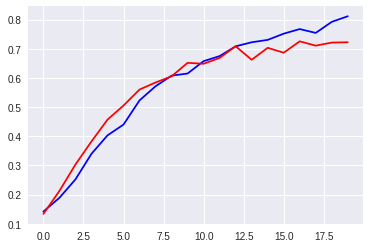

lr= 0.001 14.582162618637085  seconds
CNN Error: 27.79%


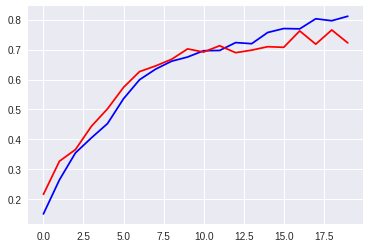

lr= 0.0001 14.593919038772583  seconds
CNN Error: 27.37%


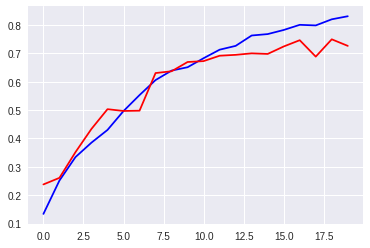

lr= 1e-05 14.65339708328247  seconds
CNN Error: 22.84%


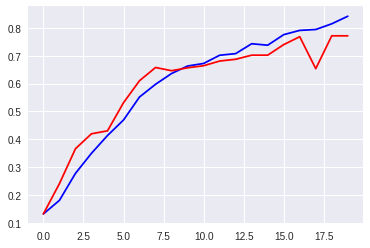

In [110]:
# Previous models for reference
  